<a href="https://colab.research.google.com/github/nurrizkyimani/mesh_on_demand/blob/master/Data_Mining_Nurrizky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Kaggle Thingy

In [ ]:
# {"username":"bocahrokok","key":"3470fa29c5901d007de08e0f97175435"}

import os 
os.environ['KAGGLE_USERNAME'] = "bocahrokok" 
os.environ['KAGGLE_KEY'] = "e84247255109e51ea31886308e848c7f"

# {"username":"bocahrokok","key":"c77b06e7a18b4931860118a28888ed31"}


# kaggle datasets download -d takuok/glove840b300dtxt

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/datamining/"


In [ ]:
%cd /content/drive/MyDrive/datamining/

[Errno 2] No such file or directory: '/content/drive/MyDrive/datamining/'
/content


In [ ]:
!kaggle datasets download -d takuok/glove840b300dtxt --unzip

 99% 2.07G/2.08G [00:30<00:00, 121MB/s]
100% 2.08G/2.08G [00:30<00:00, 73.5MB/s]


# Import 

In [2]:
# !pip install spacy==2.3.0
# import spacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_ner_bionlp13cg_md-0.2.5.tar.gz
# import en_ner_bionlp13cg_md
!pip install spacy==2.3.5
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz
import re, nltk, spacy, gensim
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from bs4 import BeautifulSoup
from nltk.tokenize import ToktokTokenizer
from nltk.stem import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from string import punctuation
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from keras.metrics import top_k_categorical_accuracy
from keras.optimizer_v2.adam import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D, Flatten
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import string
import itertools
import io
import json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.4 MB 24.7 MB/s 
     |████████████████████████████████| 1.0 MB 48.6 MB/s 
     |████████████████████████████████| 184 kB 55.2 MB/s 
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.3
    Uninstalling srsly-2.4.3:
      Successfully uninstalled srsly-2.4.3
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.7
    Uninstalling catalogue-2.0.7:
      Successfully uninstalled catalogue-2.0.7
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.17
    Uninstalling thinc-8.0.17:
      Successfully uninstalled thinc-8.0.17
  Attempting uninstall: spacy
    Found existing installation: spacy 3.3.1
    Uninstalling spacy-3.3.1:
      Successfully uninstalled spacy-3.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beh

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Data loading

In [ ]:
path = "/content/drive/MyDrive/datamining/"
indonesia_txt = path + "pubmed-indonesia-set.txt"
headache_txt = path + "pubmed-headache-set.txt"
longevity_txt = path + "pubmed-longevity-set.txt"
txt_labels = ["indonesia", "headache", 'longevity']
txt_paths = [indonesia_txt, headache_txt, longevity_txt]



In [ ]:
#load file glove untuk embedding; this is embedding cell; 
glove_file = "/content/drive/MyDrive/datamining/glove.840B.300d.txt"
emb_dict = {}
glove = open(glove_file, encoding="utf-8")
for line in glove:
  values = line.split()
  word = values[0]
  try :
    vector = np.asarray(values[1:], dtype="float32")
  except :
    continue
  emb_dict[word] = vector
glove.close()

In [ ]:
#f
def get_abstract_and_mh(lines):
  s = "".join(lines)
  s = re.sub("\n\s+", "", s)
  s = s.strip()
  s = s.split("\n")

  abstract = ""
  mh = []
  for line in s:
    if line[0:5]=="AB  -":
      abstract = line[6:]
    elif line[0:5]=="MH  -":
      mh.append(line[6:])
  return [abstract, mh]

In [ ]:
# open the each file in drive, and add it into the record array; so we create new dataset; 
records = []
for i, p in enumerate(txt_paths):
  f = open(p, "r")
  temp_record = []
  r = []
  for line in f:
    if line != "\n":
      r.append(line)
    else :
      temp_record.append(get_abstract_and_mh(r))
      r = []
  f.close()
  records.append(temp_record)

In [ ]:
records[0][5]

['BACKGROUND: Indonesia is the largest island country in the world with diverse ethnicity and cultural backgrounds. This study aimed to understand the variation in attitudes toward epilepsy among the Javanese, Sundanese, and the Minahasa ethnic groups in Indonesia. METHOD: This study recruited Sundanese from Tasikmalaya and Minahasan from Manado using the Indonesian Public Attitudes Toward Epilepsy (PATE) scale. The results were compared to the Javanese and Malaysian data in previous studies. RESULT: A total of 200 respondents, 100 from each ethnic group were recruited, with a mean age of 38.51\u202fyears. They were predominantly females (54%) and had secondary education level or lower (56.67%). The Javanese had a higher total mean score, indicating poorer attitudes toward epilepsy, as compared to the Minahasan and Sundanese groups. These differences were noted in the personal domain, but not the general domain. There were no significant differences in the mean scores in both personal 

In [ ]:
# records : the first list with a list on it called; 
# 2nd list: list of ['abstract', 'list of the 'label']
# 3rd list: ['abstract', 'list of the label']

# Preprocessing: Lemmatization, Cleaning, stopWordsRemove; CombineRecord

In [ ]:
token = ToktokTokenizer()
stop_words = set(stopwords.words("english"))
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
punct = punctuation

def clean_text(text):
    ''' Lowering text and removing undesirable marks
    '''
    
    text = re.sub("\d+", "", text)
    text = text.lower()
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text) # matches all whitespace characters
    text = text.strip(' ')
    return text
  
def strip_list_noempty(mylist):
    
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']
    
    
def clean_punct(text): 
    ''' Remove punctuations'''
    words = token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    
    for w in words:
        w = re.sub('^[0-9]*', " ", w)
        punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))
  
def stopWordsRemove(text):
    ''' Removing all the english stop words from a corpus
    Parameter:
    text: corpus to remove stop words from it
    '''
    words = token.tokenize(text)
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))
  
def lemmatization(texts, allowed_postags, stop_words=stop_words):
    ''' It keeps the lemma of the words (lemma is the uninflected form of a word),
    and deletes the underired POS tags
    
    Parameters:
    
    texts (list): text to lemmatize
    allowed_postags (list): list of allowed postags, like NOUN, ADL, VERB, ADV
    '''
    lemma = wordnet.WordNetLemmatizer()       
    doc = nlp(texts) 
    texts_out = []
    
    for token in doc:
        if token.pos_ in allowed_postags:
            
          if token.lemma_ not in ['-PRON-']:
              texts_out.append(token.lemma_)
              
          else:
              texts_out.append('')
     
    texts_out = ' '.join(texts_out)

    return texts_out

In [ ]:
for r in records:
  for d in r:
    d[0] = clean_text(d[0])
    d[0] = BeautifulSoup(d[0]).get_text()
    d[0] = clean_punct(d[0])
    d[0] = stopWordsRemove(d[0])
    d[0] = lemmatization(d[0], ["NOUN", "ADV", "ADL", "VERB"])

In [ ]:
records[1][0]

['type headache moreover people type headache time treatment basis diagnosis technically term content diagnostic process base classification disorder beta produce classification base distinction headache application uniform concept come treatment type headache',
 ['Headache/*classification/*diagnosis', 'Humans']]

In [ ]:
# RECORD_COMBINED : our holygrail of the processed dataset; 
records_combined = list(itertools.chain.from_iterable(records))

In [ ]:
records_df_pre = pd.DataFrame (records_combined, columns=['abstract', 'tags'])

In [ ]:
tl = records_df_pre["tags"][0]

type(tl)

list

In [ ]:
# remove the nan row; 

records_df_pre['abstract'].replace('', np.nan, inplace=True)
records_df_drop = records_df_pre.dropna().reset_index(drop=True)

In [ ]:
records_df_drop

,abstract,tags
0,problem country greatly affect case fatality r...,"[*Betacoronavirus, COVID-19, Coronavirus Infec..."
1,advance diagnosis management lead improvement ...,"[Adult, *Eisenmenger Complex, Female, *Heart D..."
2,project world prepare age society country worl...,"[Health Status, *Healthy Aging, Humans, Indone..."
3,country world share particularly burden case s...,"[Humans, Incidence, Indonesia/epidemiology, Sn..."
4,island country world ethnicity background stud...,"[Adult, *Attitude, *Epilepsy/epidemiology, Fem..."
...,...,...
19996,age ca determine time birth age base change le...,"[Adult, Aged, Aged, 80 and over, Biomarkers, *..."
19997,specie use interaction cope challenge environm...,"[Adaptation, Psychological, Animals, Female, *..."
19998,age become concern worldwide therefore signifi...,"[Animals, Gene Knockout Techniques, *Longevity..."
19999,work show sweetener ingest study assess toxici...,"[Animals, Drosophila melanogaster/*drug effect..."


In [ ]:
for i in records_df_drop['tags'][0]:
  print(i)

*Betacoronavirus
COVID-19
Coronavirus Infections/*epidemiology
Humans
Indonesia/epidemiology
Pandemics
Pneumonia, Viral/*epidemiology
SARS-CoV-2


In [ ]:
path = "/content/drive/MyDrive/datamining/"
records_df_drop.to_csv(path + 'records_combined.csv', index=False)

# Visualisation

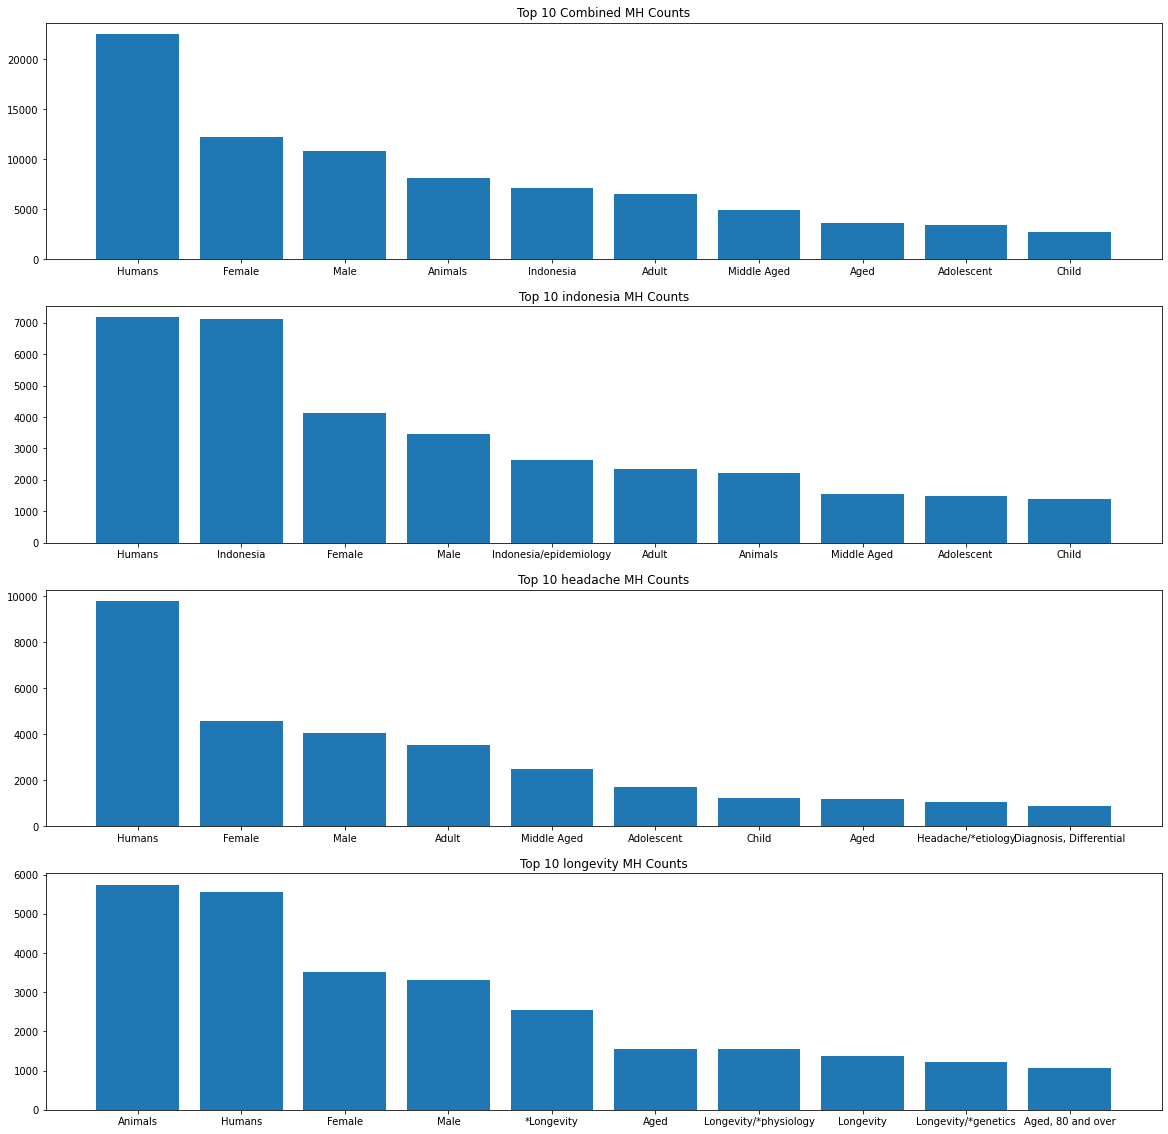

In [ ]:
mh_list = []
for d in records_combined:
  mh_list += d[1]
values, counts = np.unique(mh_list, return_counts=True)

fig, axs = plt.subplots(4, figsize=(20, 20))
ind = (-counts).argsort()[:10]
axs[0].set_title("Top 10 Combined MH Counts")
axs[0].bar(values[ind], counts[ind])

for i in range(len(records)):
  mh_list = []
  for d in records[i]:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:10]
  axs[i+1].set_title("Top 10 {} MH Counts".format(txt_labels[i]))
  axs[i+1].bar(values[ind], counts[ind])

In [ ]:
def show_wordcloud(records, tag, bg_color):
  combined_text = ""
  for r in records:
    if tag in r[1]:
      combined_text += r[0]

  wordcloud = WordCloud(width = 800, height = 800,
                background_color = bg_color,
                min_font_size = 10).generate(combined_text)
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

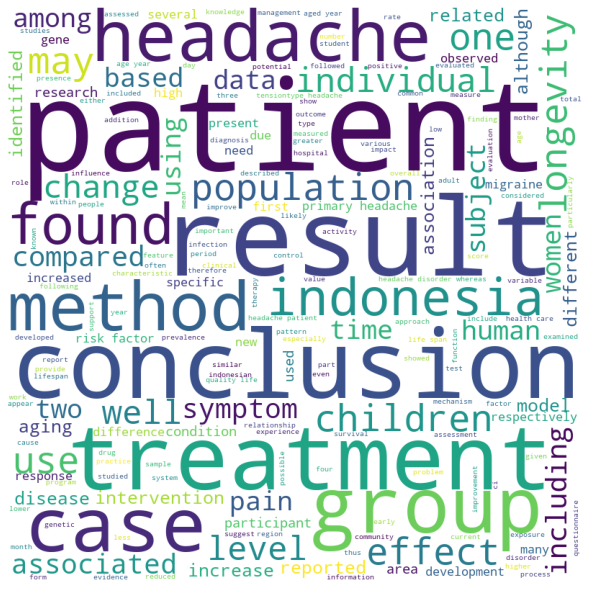

In [ ]:
show_wordcloud(records_combined, "Humans", "white")

In [ ]:
records_combined[0][1]

['*Betacoronavirus',
 'COVID-19',
 'Coronavirus Infections/*epidemiology',
 'Humans',
 'Indonesia/epidemiology',
 'Pandemics',
 'Pneumonia, Viral/*epidemiology',
 'SARS-CoV-2']

# Machine LEARNING

## Logistic Regression-Combined

In [ ]:
import pickle
from joblib import dump, load


def one_v_all_learning(records):
  X = []
  y = []
  for d in records:
    X.append(d[0])
    y.append(d[1])
  X = np.array(X)
  y = np.array(y)
  # Sampling dataset
  vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
  # 80/20 split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2,train_size=0.8, random_state=0)

  # TF-IDF matrices
  X_tfidf_train = vectorizer_X.fit_transform(X_train)
  X_tfidf_test = vectorizer_X.transform(X_test)

  #dimensionality reduction dengan PCA
  pca = PCA(n_components=0.95)
  X_tfidf_train = pca.fit_transform(X_tfidf_train.todense())
  X_tfidf_test = pca.transform(X_tfidf_test.todense())

  mh_list = []
  for d in records:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:10]
  top_tags = values[ind]
  print(top_tags)
  reports = {}
  for i in range(len(top_tags)):
    y_train_temp = [1 if top_tags[i] in row else 0 for row in y_train]
    y_test_temp = [1 if top_tags[i] in row else 0 for row in y_test]
    # model 
    clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1)
    #fit into the data; 
    clf.fit(X_tfidf_train, y_train_temp)
    
    # save the model to disk
    # pic_path = path + '/logisticmodel/'
    joblib_path = path + '/joblibmodel/'
    # filename =  pic_path + '{}_model.sav'.format(top_tags[i])
    filename_jl =  joblib_path + '{}_model.joblib'.format(top_tags[i])
    # pickle.dump(clf, open(filename, 'wb'))

    dump(clf, filename_jl ) 
    
    # predict from the model 
    preds = clf.predict(X_tfidf_test)


    print("Hasil Klasifikasi Kelas {}".format(top_tags[i]))
    print(classification_report(y_test_temp, preds))
    reports[top_tags[i]] = classification_report(y_test_temp, preds, output_dict=True)
  return reports

In [ ]:
logreg_report_combined = one_v_all_learning(records_combined)
# report_combined = one_v_all_learning(records_combined)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


['Humans' 'Female' 'Male' 'Animals' 'Indonesia' 'Adult' 'Middle Aged'
 'Aged' 'Adolescent' 'Child']
Hasil Klasifikasi Kelas Humans
              precision    recall  f1-score   support

           0       0.83      0.63      0.72      1484
           1       0.89      0.96      0.92      4516

    accuracy                           0.88      6000
   macro avg       0.86      0.79      0.82      6000
weighted avg       0.87      0.88      0.87      6000

Hasil Klasifikasi Kelas Female
              precision    recall  f1-score   support

           0       0.76      0.88      0.81      3564
           1       0.77      0.58      0.66      2436

    accuracy                           0.76      6000
   macro avg       0.76      0.73      0.74      6000
weighted avg       0.76      0.76      0.75      6000

Hasil Klasifikasi Kelas Male
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      3846
           1       0.74      0.53      0.62   

## Logistic Regression-Result Visualization

In [ ]:
def get_average_accuracy(reports):
  accuracy = [r["accuracy"] for r in list(reports.values())]
  return sum(accuracy)/len(accuracy)

def get_average_precision(reports):
  precision = [r["1"]["precision"] for r in list(reports.values())]
  return sum(precision)/len(precision)

def get_average_recall(reports):
  recall = [r["1"]["recall"] for r in list(reports.values())]
  return sum(recall)/len(recall)

def get_average_f1(reports):
  f1 = [r["1"]["f1-score"] for r in list(reports.values())]
  return sum(f1)/len(f1)

<BarContainer object of 1 artists>

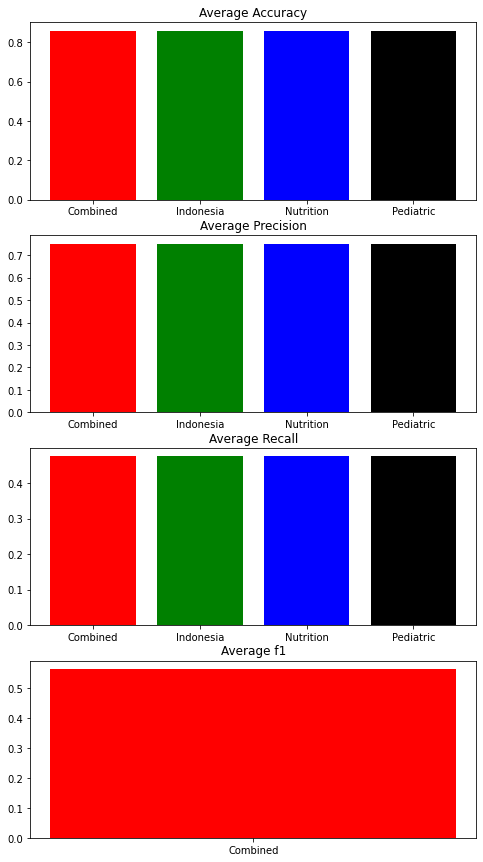

In [ ]:
fig, axs = plt.subplots(4, figsize=(8, 15))
color = ["red", "green", "blue", "black"]

report_combined = logreg_report_combined

axs[0].set_title("Average Accuracy")
acc_vals = [
            get_average_accuracy(report_combined),
            # get_average_accuracy(report_indo),
            # get_average_accuracy(report_nutrition),
            # get_average_accuracy(report_pediatric)
]
axs[0].bar(
    ["Combined", "Indonesia", "Nutrition", "Pediatric"],
    acc_vals,
    color = color
)

axs[1].set_title("Average Precision")
precision_vals = [
            get_average_precision(report_combined),
            # get_average_precision(report_indo),
            # get_average_precision(report_nutrition),
            # get_average_precision(report_pediatric)
]
axs[1].bar(
    ["Combined", "Indonesia", "Nutrition", "Pediatric"],
    precision_vals,
    color = color
)

axs[2].set_title("Average Recall")
recall_vals = [
            get_average_recall(report_combined),
            # get_average_recall(report_indo),
            # get_average_recall(report_nutrition),
            # get_average_recall(report_pediatric)
]
axs[2].bar(
    ["Combined", "Indonesia", "Nutrition", "Pediatric"],
    recall_vals,
    color = color
)

axs[3].set_title("Average f1")
f1_vals = [
            get_average_f1(report_combined),
            # get_average_f1(report_indo),
            # get_average_f1(report_nutrition),
            # get_average_f1(report_pediatric)
]
axs[3].bar(
    ["Combined",
    #  "Indonesia", "Nutrition", "Pediatric"
     ],
    f1_vals,
    color = color
)

## LSTM - Combined

In [ ]:
def lstm_multilabel_training(records):
  n_top_tags = 100
  mh_list = []
  for d in records:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:n_top_tags]
  used_mh = values[ind]

  X = []
  y = []
  for d in records:
    X.append(d[0])
    y.append([mh for mh in d[1] if mh in used_mh])
  X = np.array(X)
  y = np.array(y)

  # The maximum number of words to be used. (most frequent)
  MAX_NB_WORDS = 30000
  # Max number of words in each abstract.
  MAX_SEQUENCE_LENGTH = 250
  # This is fixed.
  EMBEDDING_DIM = 300

  filter = np.array([len(t)!=0 for t in y])
  X_lstm = np.array(X)[filter]
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
  tokenizer.fit_on_texts(X_lstm)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  X_lstm = tokenizer.texts_to_sequences(X_lstm)
  X_lstm = pad_sequences(X_lstm, maxlen=MAX_SEQUENCE_LENGTH)
  print('Shape of data tensor:', X_lstm.shape)
  
  emb_matrix = np.zeros((MAX_NB_WORDS, EMBEDDING_DIM))
  for w, i in tokenizer.word_index.items():
      if i < MAX_NB_WORDS:
          vect = emb_dict.get(w)
          if vect is not None:
            emb_matrix[i] = vect
      else:
          break
  tags = pd.get_dummies(pd.Series(y).apply(pd.Series).stack()).sum(level=0)
  y_lstm = tags.values
  print('Shape of label tensor:', y_lstm.shape)
  X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(
        X_lstm,
        y_lstm, 
        test_size = 0.10, 
        random_state = 42)
  
  model = Sequential()
  model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_lstm.shape[1]))
  model.add(SpatialDropout1D(0.2))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(n_top_tags, activation='sigmoid'))
  o = Adam(lr=0.001)
  model.compile(loss='binary_crossentropy', optimizer=o, metrics=[top_k_categorical_accuracy])
  model.layers[0].set_weights([emb_matrix])
  model.layers[0].trainable = False

  epochs = 1
  batch_size = 64
  # batch_size = 1000

  history = model.fit(X_lstm_train, y_lstm_train, epochs=epochs,
                      batch_size=batch_size,
                      validation_split=0.1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])
  
  accr = model.evaluate(X_lstm_test,y_lstm_test)
  print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
  return model, accr[1], y

In [ ]:
model, lstm_acc_combined, y = lstm_multilabel_training(records_combined)
print(lstm_acc_combined)

NameError: ignored

In [ ]:
model.save('/content/drive/MyDrive/datamining/h5model.h5', save_format='h5')

In [ ]:

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 30000
# Max number of words in each abstract.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 300


tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

X = []
for d in records_combined[0:1]:
  X.append(d[0])
X = np.array(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
preds = model.predict(X)

In [ ]:
preds

In [ ]:
tags = pd.get_dummies(pd.Series(y).apply(pd.Series).stack()).sum(level=0)
tags.columns.values

In [ ]:
threshold = 0.5
idx = np.where(preds[0]>threshold)[0]
idx

In [ ]:
tag_names = tags.columns.values
tag_names[preds[0]>threshold]

In [ ]:
tag_lstm = [tag_names[p>threshold] for p in preds]
tag_lstm[0:5]

# Clustering Method

In [ ]:
records_combined[0]

['coronavirus disease covid pandemic ongoing problem countries world indonesia greatly affected covid case fatality rate cfr end march room improvement related unreadingess healthcare facility major steps taken government suggested country stricter stayathome notice suppress spread imposing lockdown large scale improve healthcare service increase availability personal protective equipments ppe important avoid epidemic peak potentially overwhelms healthcare service quarantining case contacts lockdown may prolong epidemic doubling time significantly demand health system likely grow since number covid case likely rise effective procedures protecting medical staff infection essential scientific research indonesia also crucial provide suggestion recommendation pertinent covid',
 ['*Betacoronavirus',
  'COVID-19',
  'Coronavirus Infections/*epidemiology',
  'Humans',
  'Indonesia/epidemiology',
  'Pandemics',
  'Pneumonia, Viral/*epidemiology',
  'SARS-CoV-2']]

In [ ]:
def transform_kmeans(records):
  X = []
  y = []
  for d in records:
    X.append(d[0])
    y.append(d[1])
  X = np.array(X)
  y = np.array(y)

  # Sampling dataset
  vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
  # 80/20 split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2,train_size=0.8, random_state=0)

  # TF-IDF matrices
  X_tfidf_train = vectorizer_X.fit_transform(X_train)
  X_tfidf_test = vectorizer_X.transform(X_test)

  #dimensionality reduction dengan PCA
  pca = PCA(n_components=0.95)
  X_tfidf_train = pca.fit_transform(X_tfidf_train.todense())
  X_tfidf_test = pca.transform(X_tfidf_test.todense())

  mh_list = []
  for d in records:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:10]
  top_tags = values[ind]
  print(top_tags)

  print(type(X_tfidf_train))
  print(type(X_tfidf_test))

  return X_tfidf_train, X_tfidf_test, top_tags








In [ ]:
X_tfidf_train, X_tfidf_test, top_tags = transform_kmeans(records_combined)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


['Humans' 'Female' 'Male' 'Animals' 'Indonesia' 'Adult' 'Middle Aged'
 'Aged' 'Adolescent' 'Child']
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def clustering_kmeans(records):
  X = []
  y = []

  for d in records:
    X.append(d[0])
    y.append(d[1])

  X = np.array(X)
  y = np.array(y)

  # Sampling dataset
  vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
  # 80/20 split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2,train_size=0.8, random_state=0)

  # TF-IDF matrices
  X_tfidf_train = vectorizer_X.fit_transform(X_train)
  X_tfidf_test = vectorizer_X.transform(X_test)

  #dimensionality reduction dengan PCA
  pca = PCA(n_components=0.95)
  X_tfidf_train = pca.fit_transform(X_tfidf_train.todense())
  X_tfidf_test = pca.transform(X_tfidf_test.todense())

  mh_list = []
  for d in records:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:10]
  top_tags = values[ind]
  print(top_tags)

  print(type(X_tfidf_train))
  print(type(X_tfidf_test))


  true_k = len(top_tags)
  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)
  model.fit(X_tfidf_train)

  print("Top terms per cluster:")
  order_centroids = model.cluster_centers_.argsort()[:, ::-1]
  terms = vectorizer_X.get_feature_names()
  for i in range(true_k):
      print("Cluster %d:" % i),
      for ind in order_centroids[i, :10]:
          print(' %s' % terms[ind]),
      print

  print("\n")
  print("Prediction")

  return model 

In [ ]:
cluster_model = clustering_kmeans(records_combined)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


['Humans' 'Female' 'Male' 'Animals' 'Indonesia' 'Adult' 'Middle Aged'
 'Aged' 'Adolescent' 'Child']
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Top terms per cluster:
Cluster 0:
 csf
 confirmed
 absence
 approximately
 al
 disorder
 comparison
 also
 developed
 efficacy
Cluster 1:
 activities
 active
 according
 addition
 aging
 along
 activity
 area
 among
 almost
Cluster 2:
 around
 animals
 approximately
 ability
 anxiety
 another
 application
 aging
 approaches
 associated
Cluster 3:
 absence
 according
 across
 adolescents
 addition
 also
 agerelated
 alternative
 aim
 ages
Cluster 4:
 access
 absence
 acute
 accumulation
 action
 animal
 adverse
 appropriate
 ages
 allele
Cluster 5:
 appears
 access
 allele
 applied
 aim
 common
 demonstrate
 anxiety
 design
 aims
Cluster 6:
 account
 accumulation
 active
 additional
 activities
 absence
 access
 adjusted
 aging
 age
Cluster 7:
 ability
 absence
 account
 active
 acute
 activities
 adolescents
 action
 adjusted
 aimed
Cluster

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
prediction = cluster_model.predict(X_tfidf_test)
print(prediction)

[7 9 9 ... 6 0 6]


In [ ]:
rs = X_tfidf_test[1].reshape(1,-1)
prediction_test = cluster_model.predict(rs)
print(prediction_test)

[9]


# Draft Evaluation Matrix

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from sklearn.metrics import silhouette_samples, silhouette_score, rand_score

def clustering_kmeans_2(records):
  X = []
  y = []

  for d in records:
    X.append(d[0])
    y.append(d[1])

  X = np.array(X)
  y = np.array(y)

  # Sampling dataset
  vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
  # 80/20 split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2,train_size=0.8, random_state=0)

  # TF-IDF matrices
  X_tfidf_train = vectorizer_X.fit_transform(X_train)
  X_tfidf_test = vectorizer_X.transform(X_test)

  #dimensionality reduction dengan PCA
  pca = PCA(n_components=0.95)
  X_tfidf_train = pca.fit_transform(X_tfidf_train.todense())
  X_tfidf_test = pca.transform(X_tfidf_test.todense())

  mh_list = []
  for d in records:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:20]
  top_tags = values[ind]
  print("top tags for cluster:  ", top_tags)


  true_k = len(top_tags)
  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)
  cluster_labels = model.fit_predict(X_tfidf_train)


  # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
  silhouette_avg = silhouette_score(X_tfidf_train, cluster_labels)
  print(
      "For n_clusters =",
      true_k,
      "The average silhouette_score is :",
      silhouette_avg,
  )

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(X_tfidf_train, cluster_labels)

  # rand_avg = rand_score(X_tfidf_train, cluster_labels)

  print("Top terms per cluster:")
  order_centroids = model.cluster_centers_.argsort()[:, ::-1]
  terms = vectorizer_X.get_feature_names()
  for i in range(true_k):
      print("Cluster %d:" % i),
      print("Cluster : ", top_tags[i]),
      for ind in order_centroids[i, :10]:
          print(' %s' % terms[ind]),
      print

  print("\n")
  print("Prediction")

  return model 



In [ ]:
cluster_model = clustering_kmeans_2(records_combined)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


top tags for cluster:   ['Humans' 'Female' 'Male' 'Animals' 'Indonesia' 'Adult' 'Middle Aged'
 'Aged' 'Adolescent' 'Child' 'Indonesia/epidemiology' '*Longevity'
 'Aged, 80 and over' 'Longevity/*physiology' 'Child, Preschool'
 'Young Adult' 'Longevity' 'Cross-Sectional Studies' 'Longevity/*genetics'
 'Prevalence']
For n_clusters = 20 The average silhouette_score is : 0.17629936899505314
Top terms per cluster:
Cluster 0:
Cluster :  Humans
 activities
 active
 according
 addition
 aging
 along
 aged
 almost
 activity
 area
Cluster 1:
Cluster :  Female
 absence
 action
 additional
 according
 accumulation
 adults
 activities
 age
 ageing
 allele
Cluster 2:
Cluster :  Male
 access
 absence
 additional
 active
 accumulation
 adolescents
 across
 ageing
 action
 activities
Cluster 3:
Cluster :  Animals
 account
 active
 accumulation
 additional
 activities
 adjusted
 access
 age
 absence
 acid
Cluster 4:
Cluster :  Indonesia
 absence
 across
 account
 according
 ageing
 agerelated
 ages
 adol

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# UAS : Clustering IUP

In [ ]:

path = "/content/drive/MyDrive/datamining/"

df = pd.read_csv(path + "uas_dataset.csv")

In [ ]:
df.head()

,A00,0,A000,"Cholera due to Vibrio cholerae 01, biovar cholerae","Cholera due to Vibrio cholerae 01, biovar cholerae.1",Cholera
0,A00,1,A001,"Cholera due to Vibrio cholerae 01, biovar eltor","Cholera due to Vibrio cholerae 01, biovar eltor",Cholera
1,A00,9,A009,"Cholera, unspecified","Cholera, unspecified",Cholera
2,A010,0,A0100,"Typhoid fever, unspecified","Typhoid fever, unspecified",Typhoid fever
3,A010,1,A0101,Typhoid meningitis,Typhoid meningitis,Typhoid fever
4,A010,2,A0102,Typhoid fever with heart involvement,Typhoid fever with heart involvement,Typhoid fever


In [ ]:
y = df.pop('Cholera')
X = df

X_train,X_test,y_train,y_test = train_test_split(X.index,y,test_size=0.2)

In [ ]:
records_combined[0][1]

['*Betacoronavirus',
 'COVID-19',
 'Coronavirus Infections/*epidemiology',
 'Humans',
 'Indonesia/epidemiology',
 'Pandemics',
 'Pneumonia, Viral/*epidemiology',
 'SARS-CoV-2']

In [ ]:
df.head()

,A00,0,A000,"Cholera due to Vibrio cholerae 01, biovar cholerae","Cholera due to Vibrio cholerae 01, biovar cholerae.1",Cholera
0,A00,1,A001,"Cholera due to Vibrio cholerae 01, biovar eltor","Cholera due to Vibrio cholerae 01, biovar eltor",Cholera
1,A00,9,A009,"Cholera, unspecified","Cholera, unspecified",Cholera
2,A010,0,A0100,"Typhoid fever, unspecified","Typhoid fever, unspecified",Typhoid fever
3,A010,1,A0101,Typhoid meningitis,Typhoid meningitis,Typhoid fever
4,A010,2,A0102,Typhoid fever with heart involvement,Typhoid fever with heart involvement,Typhoid fever


In [ ]:
df.columns



df_pop = df.copy()

y_cho = df_pop.pop('Cholera')
# X = df_pop

X_due = df_pop.pop('Cholera due to Vibrio cholerae 01, biovar cholerae')

In [ ]:
y_cho.head()

0          Cholera
1          Cholera
2    Typhoid fever
3    Typhoid fever
4    Typhoid fever
Name: Cholera, dtype: object

In [ ]:
X_due.head()

0    Cholera due to Vibrio cholerae 01, biovar eltor
1                               Cholera, unspecified
2                         Typhoid fever, unspecified
3                                 Typhoid meningitis
4               Typhoid fever with heart involvement
Name: Cholera due to Vibrio cholerae 01, biovar cholerae, dtype: object

In [ ]:
cho_result = pd.concat([X_due, y_cho], axis=1, join='inner')

In [ ]:
len(cho_result)

71703

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


['h']
<class 'numpy.ndarray'>
<class 'scipy.sparse.csr.csr_matrix'>
For n_clusters = 2 The average silhouette_score is : 0.030159362482350772
For n_clusters = 3 The average silhouette_score is : 0.038882119276978204
For n_clusters = 4 The average silhouette_score is : 0.044436597790576585


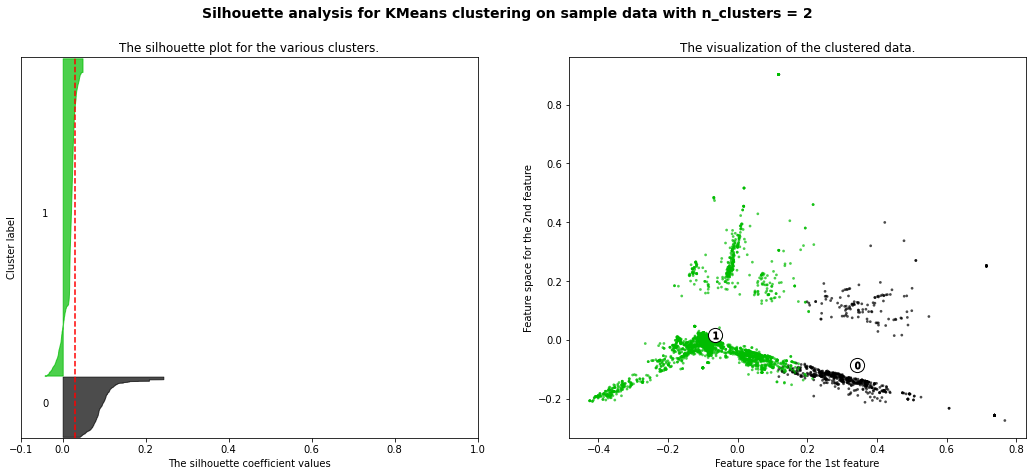

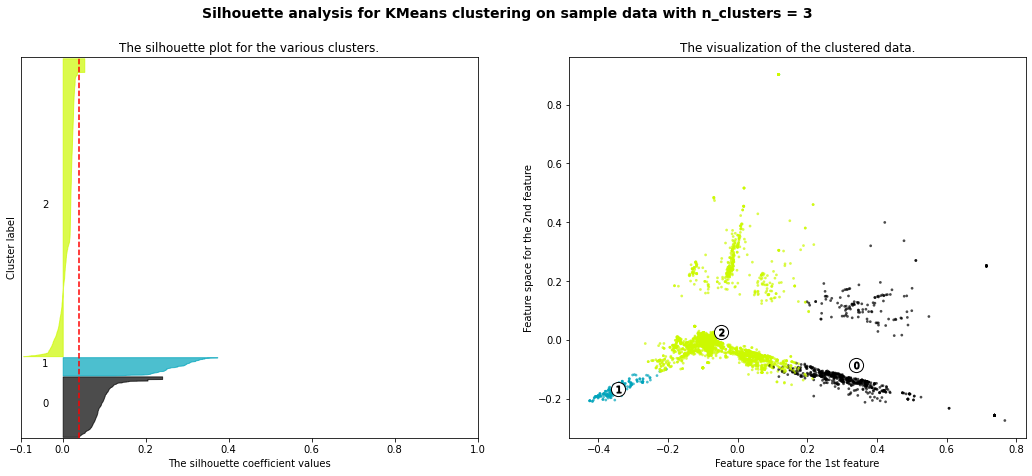

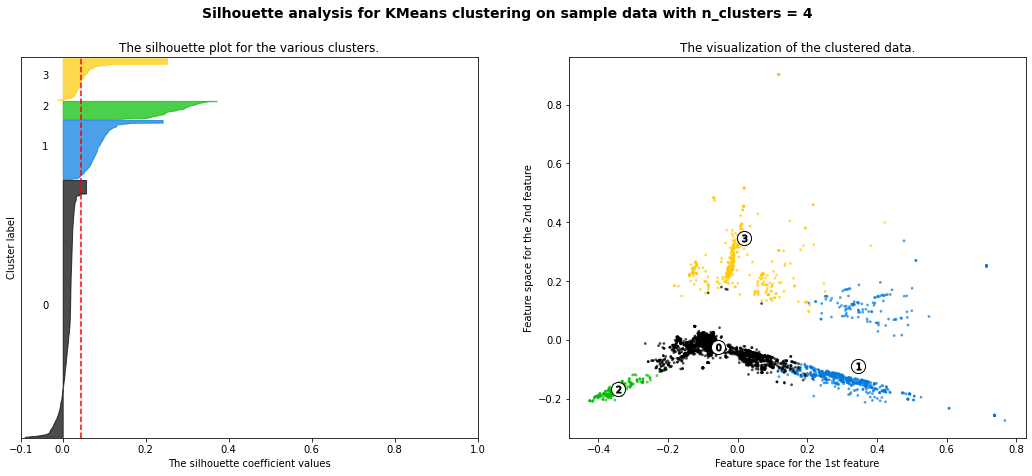

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np



# for index, row in df.iterrows():


cho_res_1000 = cho_result.iloc[0:5000]


X = []
y = []


for index, row in cho_res_1000.iterrows():
  X.append(row[0])
  y.append(row[1])


X = np.array(X)
y = np.array(y)

# Sampling dataset
vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                  strip_accents = None, encoding = 'utf-8', 
                                  preprocessor=None, 
                                  token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                  max_features=1000)
# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,train_size=0.8, random_state=0)

# TF-IDF matrices
X_tfidf_train = vectorizer_X.fit_transform(X_train)
X_tfidf_test = vectorizer_X.transform(X_test)

#dimensionality reduction dengan PCA
pca = PCA(n_components=0.95)
X_tfidf_train = pca.fit_transform(X_tfidf_train.todense())
# X_tfidf_test = pca.transform(X_tfidf_test.todense())

mh_list = []
for d in cho_result:
  mh_list += d[1]
values, counts = np.unique(mh_list, return_counts=True)
ind = (-counts).argsort()[:10]
top_tags = values[ind]
print(top_tags)

print(type(X_tfidf_train))
print(type(X_tfidf_test))


X = X_tfidf_train
y = y


range_n_clusters = [2, 3, 4 ]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def clustering_kmeans(records):
  X = []
  y = []

  for index, row in records.iterrows():
    X.append(row[0])
    y.append(row[1])

  X = np.array(X)
  y = np.array(y)

  # Sampling dataset
  vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
  # 80/20 split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2,train_size=0.8, random_state=0)

  # TF-IDF matrices
  X_tfidf_train = vectorizer_X.fit_transform(X_train)
  X_tfidf_test = vectorizer_X.transform(X_test)

  #dimensionality reduction dengan PCA
  pca = PCA(n_components=0.95)
  X_tfidf_train = pca.fit_transform(X_tfidf_train.todense())
  X_tfidf_test = pca.transform(X_tfidf_test.todense())

  mh_list = []
  for index, row in records.iterrows():
    mh_list += row[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:10]
  top_tags = values[ind]
  print(top_tags)

  print(type(X_tfidf_train))
  print(type(X_tfidf_test))


  true_k = len(top_tags)
  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)
  model.fit(X_tfidf_train)

  print("Top terms per cluster:")
  order_centroids = model.cluster_centers_.argsort()[:, ::-1]
  terms = vectorizer_X.get_feature_names()
  for i in range(true_k):
      print("Cluster %d:" % i),
      for ind in order_centroids[i, :10]:
          print(' %s' % terms[ind]),
      print

  print("\n")
  print("Prediction")

  return model 

In [ ]:
cluster_model = clustering_kmeans(cho_res_1000)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


[' ' 'e' 'i' 'a' 'o' 'n' 't' 's' 'r' 'l']
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Top terms per cluster:
Cluster 0:
 acc
 abdominal
 (chronic)
 acute
 [men]
 achieved
 acquired
 abuse,
 adrenoleukodystrophy
 adjustment
Cluster 1:
 acanthamoeba
 abuse
 achieve
 (thymic)
 activation
 acute
 adjustment
 (poly)neuropathy
 apnea
 angiopathy
Cluster 2:
 (stec)
 [men]
 acc
 abscess
 absence
 accessory
 acanthamoeba
 cause
 adenovirus
 bladder
Cluster 3:
 (chronic)
 (poly)neuropathy
 (thymic)
 acanthamoeba
 absence
 accessory
 acoustic
 acc
 angiopathy
 auricular
Cluster 4:
 (chronic)
 abuse
 abdominal
 achieve
 abuse,
 agents
 (poly)neuropathy
 acid
 adult
 acoustic
Cluster 5:
 (diffuse)
 (poly)neuropathy
 (chronic)
 (stec)
 abuse
 anemias
 acanthamoeba
 albinism
 acid
 [men]
Cluster 6:
 (thymic)
 [men]
 abdominal
 achieve
 abuse,
 (diffuse)
 activation
 alcoh-induce
 angiopathy
 abscess
Cluster 7:
 acute
 abdominal
 adjustment
 absence
 actinomycosis
 and
 alcoh-induce
 adrenoleukody

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Sequential Pattern

# Association Rule and Frequent Itemset

In [2]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules

In [3]:
path = "/content/drive/MyDrive/datamining/"
records_csv = 'records_combined.csv'

records_df = pd.read_csv(path + records_csv)

In [4]:
records_df



,abstract,tags
0,problem country greatly affect case fatality r...,"['*Betacoronavirus', 'COVID-19', 'Coronavirus ..."
1,advance diagnosis management lead improvement ...,"['Adult', '*Eisenmenger Complex', 'Female', '*..."
2,project world prepare age society country worl...,"['Health Status', '*Healthy Aging', 'Humans', ..."
3,country world share particularly burden case s...,"['Humans', 'Incidence', 'Indonesia/epidemiolog..."
4,island country world ethnicity background stud...,"['Adult', '*Attitude', '*Epilepsy/epidemiology..."
...,...,...
19996,age ca determine time birth age base change le...,"['Adult', 'Aged', 'Aged, 80 and over', 'Biomar..."
19997,specie use interaction cope challenge environm...,"['Adaptation, Psychological', 'Animals', 'Fema..."
19998,age become concern worldwide therefore signifi...,"['Animals', 'Gene Knockout Techniques', '*Long..."
19999,work show sweetener ingest study assess toxici...,"['Animals', 'Drosophila melanogaster/*drug eff..."


In [5]:
from ast import literal_eval
records_df['tags'] = records_df['tags'].apply(literal_eval)

In [6]:
for i in records_df['tags'][0]:
  print(i)

*Betacoronavirus
COVID-19
Coronavirus Infections/*epidemiology
Humans
Indonesia/epidemiology
Pandemics
Pneumonia, Viral/*epidemiology
SARS-CoV-2


In [7]:
list_records_df = records_df.copy()

tag_list = []

for index, row in list_records_df.iterrows():
  temp_list = []
  
  for tag in row['tags']:
    temp_list.append(tag)
  
  tag_list.append(temp_list)


In [8]:
tag_list[0:2]

[['*Betacoronavirus',
  'COVID-19',
  'Coronavirus Infections/*epidemiology',
  'Humans',
  'Indonesia/epidemiology',
  'Pandemics',
  'Pneumonia, Viral/*epidemiology',
  'SARS-CoV-2'],
 ['Adult',
  '*Eisenmenger Complex',
  'Female',
  '*Heart Defects, Congenital',
  'Humans',
  '*Hypertension, Pulmonary/diagnosis/epidemiology/etiology',
  'Indonesia/epidemiology',
  'Pregnancy',
  '*Pulmonary Arterial Hypertension']]

In [12]:
len(tag_list)

20001

In [11]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

data = tag_list[0:1000].copy()

a = TransactionEncoder()
a_data = a.fit(data).transform(data)
df = pd.DataFrame(a_data,columns=a.columns_)
df = df.replace(False,0)
df

,"*Abortion, Induced","*Abortion, Spontaneous","*Accidents, Occupational",*Acinetobacter baumannii,*Acoustics,*Acquired Immunodeficiency Syndrome,*Acquired Immunodeficiency Syndrome/epidemiology/therapy,*Activities of Daily Living,"*Adaptation, Psychological",*Adolescent Behavior,...,Wound Infection/diagnosis/*epidemiology,Wounds and Injuries/*epidemiology/etiology,Wounds and Injuries/epidemiology,X-Ray Microtomography,Xerophthalmia/*epidemiology,Young Adult,Zimbabwe,Zinc,alpha-2-HS-Glycoprotein/genetics,alpha-Fetoproteins
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
df = apriori(df, min_support = 0.2, use_colnames = True)
df

,support,itemsets
0,0.203,(Adult)
1,0.371,(Female)
2,0.757,(Humans)
3,0.374,(Indonesia)
4,0.588,(Indonesia/epidemiology)
5,0.274,(Male)
6,0.203,"(Humans, Adult)"
7,0.344,"(Female, Humans)"
8,0.289,"(Female, Indonesia/epidemiology)"
9,0.23,"(Female, Male)"


In [14]:
df_ar = association_rules(df, metric = "confidence", min_threshold = 0.6)
df_ar

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Adult),(Humans),0.203,0.757,0.203,1.000000,1.321004,0.049329,inf
1,(Female),(Humans),0.371,0.757,0.344,0.927224,1.224866,0.063153,3.339000
2,(Female),(Indonesia/epidemiology),0.371,0.588,0.289,0.778976,1.324789,0.070852,1.864049
3,(Female),(Male),0.371,0.274,0.230,0.619946,2.262577,0.128346,1.910255
4,(Male),(Female),0.274,0.371,0.230,0.839416,2.262577,0.128346,3.916955
5,(Indonesia/epidemiology),(Humans),0.588,0.757,0.566,0.962585,1.271579,0.120884,6.494727
6,(Humans),(Indonesia/epidemiology),0.757,0.588,0.566,0.747688,1.271579,0.120884,1.632901
7,(Male),(Humans),0.274,0.757,0.239,0.872263,1.152263,0.031582,1.902343
8,(Male),(Indonesia/epidemiology),0.274,0.588,0.210,0.766423,1.303441,0.048888,1.763875
9,"(Female, Indonesia/epidemiology)",(Humans),0.289,0.757,0.282,0.975779,1.289007,0.063227,10.032429


In [15]:
rules_mesh =  association_rules(df, metric='lift', min_threshold=0.6)

In [16]:
rules_mesh

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Humans),(Adult),0.757,0.203,0.203,0.268164,1.321004,0.049329,1.089042
1,(Adult),(Humans),0.203,0.757,0.203,1.000000,1.321004,0.049329,inf
2,(Female),(Humans),0.371,0.757,0.344,0.927224,1.224866,0.063153,3.339000
3,(Humans),(Female),0.757,0.371,0.344,0.454425,1.224866,0.063153,1.152913
4,(Female),(Indonesia/epidemiology),0.371,0.588,0.289,0.778976,1.324789,0.070852,1.864049
5,(Indonesia/epidemiology),(Female),0.588,0.371,0.289,0.491497,1.324789,0.070852,1.236963
6,(Female),(Male),0.371,0.274,0.230,0.619946,2.262577,0.128346,1.910255
7,(Male),(Female),0.274,0.371,0.230,0.839416,2.262577,0.128346,3.916955
8,(Indonesia/epidemiology),(Humans),0.588,0.757,0.566,0.962585,1.271579,0.120884,6.494727
9,(Humans),(Indonesia/epidemiology),0.757,0.588,0.566,0.747688,1.271579,0.120884,1.632901
